In [1]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import os
import sys
import warnings
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter('ignore')

sys.path.append('../../utilities')
sys.path.append('../../models/grt123')
sys.path.append('../../models/grt123/training')
sys.path.append('../../models/grt123/preprocessing/')

# from layers import nms,iou
from summit_utils import SummitScan, xyz2irc
from evaluation import noduleCADEvaluation

workspace_path = Path(os.getcwd()).parent.parent


# Test Balanced Data

# Scan Metadata

In [2]:

def set_is_actionable(row):
    if row['radiology_report_management_plan_final'] in ['3_MONTH_FOLLOW_UP_SCAN','URGENT_REFERRAL', 'ALWAYS_SCAN_AT_YEAR_1']:
        return 'Actonable'
    else:
        return 'Non-Actionable'

def set_smoking_pack_years_cats(df):
    df[df['smoking_pack_years'] < 0] = np.nan
    return pd.qcut(df['smoking_pack_years'], 5, labels=False)

person_data = pd.read_csv(
    f'{workspace_path}/data/summit/data/person_data.csv',
    usecols=['LDCT_RADIOLOGY_REPORT_main_participant_id', 'lung_health_check_clinical_smoking_pack_years', 'ocd_DeprivationScore_IMDRank']
).rename(columns={
    'lung_health_check_clinical_smoking_pack_years':'smoking_pack_years',
    'ocd_DeprivationScore_IMDRank':'deprivation_score'
}).assign(
    smoking_pack_years_cats=lambda df: set_smoking_pack_years_cats(df),
    IMDRank_tertile=lambda df: pd.qcut(df['deprivation_score'], 3, labels=['Low', 'Medium', 'High']),
    IMDRank_quintile=lambda df: pd.qcut(df['deprivation_score'], 5, labels=['Low', 'Low-Medium', 'Medium', 'Medium-High', 'High']),
)
                          
scan_metadata = (
    pd.read_csv(f'{workspace_path}/metadata/summit/female_for_inference/test_scans_metadata.csv')
    .assign(name=lambda df: df['LDCT_RADIOLOGY_REPORT_main_participant_id'] + '_Y0_BASELINE_A')
    .assign(is_actionable=lambda df: df.apply(set_is_actionable, axis=1))
    .assign(gender_is_actionable=lambda df: df.apply(set_gender_is_actionable, axis=1))    
    .assign(gender_is_not_actionable=lambda df: df.apply(set_gender_is_not_actionable, axis=1))    
    .assign(ethnic_group_is_actionable=lambda df: df.apply(set_ethnic_group_is_actionable, axis=1))    
    .assign(ethnic_group_is_not_actionable=lambda df: df.apply(set_ethnic_group_is_not_actionable, axis=1))    
    .rename(columns={
        'participant_details_gender':'gender',
        'lung_health_check_demographics_race_ethnicgroup':'ethnic_group'
    })
).merge(person_data, on='LDCT_RADIOLOGY_REPORT_main_participant_id')
scan_metadata = (
    scan_metadata
    .assign(smoking_pack_years_is_actionable=lambda df: df.apply(set_smoking_pack_years_is_actionable, axis=1))
    .assign(imdrank_is_actionable=lambda df: df.apply(set_imdrank_is_actionable, axis=1))    
)


scan_metadata['smoking_pack_years_cats'].value_counts()

0.0    568
2.0    531
1.0    485
3.0    402
4.0    330
Name: smoking_pack_years_cats, dtype: int64

## GRT123

NOT-UPPER       1322
UPPER           1151
NOT_ANSWERED     516
Name: nodule_site_combined, dtype: int64

/Users/john/Projects/SOTAEvaluationNoduleDetection/models/grt123/bbox_result/trained_summit/summit/female_for_inference/female_for_inference_metadata.csv
Total number of included nodule annotations: 2989
Total number of nodule annotations: 2989
Cases: 2337
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-8739-emz_Y0_BASELINE_A, nodule Annot ID: 2448
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-5854-bku_Y0_BASELINE_A, nodule Annot ID: 1507
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: 1802
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6225-qvf_Y0_BASELINE_A, nodule Annot ID: 1561


100%|██████████| 1000/1000 [05:21<00:00,  3.11it/s]


0                   159                 476   \
0  0.16 (0.14 - 0.18)  0.23 (0.21 - 0.25)  0.33 (0.31 - 0.36)   

                 1111                2381                4920  \
0  0.45 (0.42 - 0.47)  0.56 (0.53 - 0.58)  0.66 (0.64 - 0.69)   

                 9999  
0  0.76 (0.74 - 0.78)

fps  mean_sens  low_sens  high_sens
0     0.12       0.16      0.14       0.18
159   0.25       0.23      0.21       0.25
476   0.50       0.33      0.31       0.36
1111  1.00       0.45      0.42       0.47
2381  2.00       0.56      0.53       0.58
4920  4.00       0.66      0.64       0.69
9999  8.00       0.76      0.74       0.78

Mean Sensitivity: 0.45 Low Sensitivity: 0.43 High Sensitivity: 0.47


True positives        2543
0                                    False positives  117084.000
1                                    False negatives     446.000
2                                     True negatives       0.000
3                         Total number of candidates  119695.000
4                            Total number of nodules    2989.000
5             Ignored candidates on excluded nodules       0.000
6      Ignored candidates which were double detec...      72.000
7                                        Sensitivity       0.851
8              Average number of candidates per scan      51.217

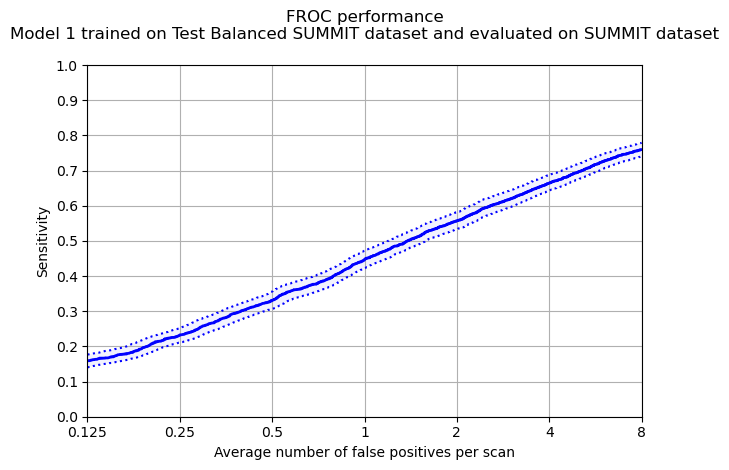

In [3]:
# Add in diameter cuts for later analysis
def combine_site(nodule_site):
    if nodule_site.find('UPPER') > -1:
        return 'UPPER'
    elif nodule_site.find('NOT') > -1:
        return 'NOT_ANSWERED'
    else:
        return 'NOT-UPPER'
    
def combine_site2(nodule_site):
    if nodule_site.find('RIGHT') > -1:
        return 'RIGHT'
    elif nodule_site.find('LEFT') > -1:
        return 'LEFT'
    else:
        return 'NOT_ANSWERED'

diameter_cats = [0, 4, 8, 15, 20, 30, 40, 999]
diameter_lbs = [f'{diameter_cats[i]:02}-{diameter_cats[i+1]:02}' for i in range(len(diameter_cats))[:-1]]

annotations = (
    pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/female_for_inference/female_for_inference_metadata.csv')
    .assign(diameter_cats=lambda df: 
        pd.cut(
            df['nodule_diameter_mm'], 
            bins=diameter_cats,
            labels=diameter_lbs
        )            
    )
    .assign(nodule_site_combined=lambda df: df['nodule_site'].apply(combine_site))
    .assign(nodule_site_combined2=lambda df: df['nodule_site'].apply(combine_site2))
)

display(annotations.nodule_site_combined.value_counts())

# save back to the metadata file
annotations.to_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/female_for_inference/female_for_inference_metadata.csv', index=False)
grt123_summit_summit = noduleCADEvaluation(
    annotations_filename=f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/female_for_inference/female_for_inference_metadata.csv',
    annotations_excluded_filename=f'{workspace_path}/data/summit/metadata/grt123_annotations_excluded_empty.csv',
    seriesuids_filename=f'{workspace_path}/metadata/summit/female_for_inference/test_scans.csv',
    results_filename=f"{workspace_path}/models/grt123/bbox_result/trained_summit/summit/female_for_inference/female_for_inference_predictions.csv",    
    filter='\nModel 1 trained on Test Balanced SUMMIT dataset and evaluated on SUMMIT dataset\n',
    outputDir=f'{workspace_path}/results/grt123/trained_summit/summit/female_for_inference',
)
caluclate_cpm_from_bootstrapping(f'{workspace_path}/results/grt123/trained_summit/summit/female_for_inference/froc_female_for_inference_predictions_bootstrapping.csv')
show_metrics(f'{workspace_path}/results/grt123/trained_summit/summit/female_for_inference/CADAnalysis.txt')

### Gender analysis

Protected Group: FEMALE


SOLID  PERIFISSURAL  PART_SOLID  NON_SOLID  CALCIFIED
nodule_type   29.0          47.0         7.0        7.0       10.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpol0pzklt/annotations.csv
Total number of included nodule annotations: 2975
Total number of nodule annotations: 2975
Cases: 2317
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-8739-emz_Y0_BASELINE_A, nodule Annot ID: 2448
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-5854-bku_Y0_BASELINE_A, nodule Annot ID: 1507
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: 1802
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6225-qvf_Y0_BASELINE_A, nodule Annot ID: 1561


100%|██████████| 1000/1000 [05:22<00:00,  3.10it/s]


0                   159                 476   \
0  0.16 (0.14 - 0.18)  0.23 (0.21 - 0.25)  0.33 (0.31 - 0.35)   

                 1111                2381                4920  \
0  0.45 (0.42 - 0.47)  0.56 (0.53 - 0.58)  0.66 (0.64 - 0.69)   

                 9999  
0  0.76 (0.74 - 0.78)

fps  mean_sens  low_sens  high_sens
0     0.12       0.16      0.14       0.18
159   0.25       0.23      0.21       0.25
476   0.50       0.33      0.31       0.35
1111  1.00       0.45      0.42       0.47
2381  2.00       0.56      0.53       0.58
4920  4.00       0.66      0.64       0.69
9999  8.00       0.76      0.74       0.78

Mean Sensitivity: 0.45 Low Sensitivity: 0.43 High Sensitivity: 0.47


True positives        2530
0                                    False positives  116137.000
1                                    False negatives     445.000
2                                     True negatives       0.000
3                         Total number of candidates  118735.000
4                            Total number of nodules    2975.000
5             Ignored candidates on excluded nodules       0.000
6      Ignored candidates which were double detec...      72.000
7                                        Sensitivity       0.850
8              Average number of candidates per scan      51.245

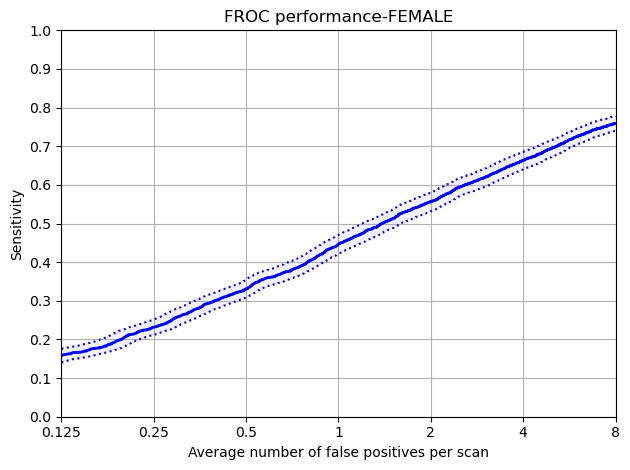

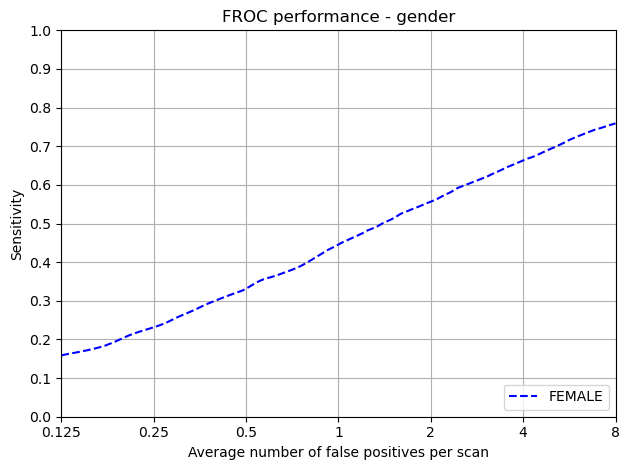

In [4]:

annotations_excluded = pd.read_csv(f'{workspace_path}/data/summit/metadata/grt123_annotations_excluded_empty.csv')

annotations = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/female_for_inference/female_for_inference_metadata.csv')

predictions = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/female_for_inference/female_for_inference_predictions.csv')

protected_group = 'gender'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/female_for_inference/{protected_group}'
)

### Ethnicity analysis

Protected Group: White


SOLID  PERIFISSURAL  PART_SOLID  NON_SOLID  CALCIFIED
nodule_type   28.0          47.0         7.0        7.0       10.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpb83jf5qm/annotations.csv
Total number of included nodule annotations: 2636
Total number of nodule annotations: 2636
Cases: 1974
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-8739-emz_Y0_BASELINE_A, nodule Annot ID: 2448
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-5854-bku_Y0_BASELINE_A, nodule Annot ID: 1507
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: 1802
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6225-qvf_Y0_BASELINE_A, nodule Annot ID: 1561


100%|██████████| 1000/1000 [04:59<00:00,  3.34it/s]


0                   159                 476   \
0  0.16 (0.14 - 0.18)  0.24 (0.21 - 0.26)  0.34 (0.31 - 0.36)   

                 1111                2381                4920  \
0  0.45 (0.42 - 0.47)  0.56 (0.53 - 0.59)  0.67 (0.64 - 0.69)   

                 9999  
0  0.76 (0.74 - 0.78)

fps  mean_sens  low_sens  high_sens
0     0.12       0.16      0.14       0.18
159   0.25       0.24      0.21       0.26
476   0.50       0.34      0.31       0.36
1111  1.00       0.45      0.42       0.47
2381  2.00       0.56      0.53       0.59
4920  4.00       0.67      0.64       0.69
9999  8.00       0.76      0.74       0.78

Mean Sensitivity: 0.45 Low Sensitivity: 0.43 High Sensitivity: 0.48


True positives        2239
0                                    False positives  101018.000
1                                    False negatives     397.000
2                                     True negatives       0.000
3                         Total number of candidates  103323.000
4                            Total number of nodules    2636.000
5             Ignored candidates on excluded nodules       0.000
6      Ignored candidates which were double detec...      70.000
7                                        Sensitivity       0.849
8              Average number of candidates per scan      52.342

Protected Group: Other ethnic groups


SOLID  PERIFISSURAL  PART_SOLID  NON_SOLID  CALCIFIED
nodule_type   32.0          36.0         4.0       15.0       13.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp89q562be/annotations.csv
Total number of included nodule annotations: 47
Total number of nodule annotations: 47
Cases: 58


100%|██████████| 1000/1000 [00:03<00:00, 311.11it/s]


0                   159                476   \
0  0.09 (0.0 - 0.21)  0.14 (0.02 - 0.27)  0.2 (0.08 - 0.34)   

                 1111                2381                4920  \
0  0.35 (0.17 - 0.55)  0.47 (0.29 - 0.68)  0.59 (0.41 - 0.76)   

                 9999  
0  0.71 (0.53 - 0.85)

fps  mean_sens  low_sens  high_sens
0     0.12       0.09      0.00       0.21
159   0.25       0.14      0.02       0.27
476   0.50       0.20      0.08       0.34
1111  1.00       0.35      0.17       0.55
2381  2.00       0.47      0.29       0.68
4920  4.00       0.59      0.41       0.76
9999  8.00       0.71      0.53       0.85

Mean Sensitivity: 0.36 Low Sensitivity: 0.21 High Sensitivity: 0.52


True positives        37
0                                    False positives  2604.000
1                                    False negatives    10.000
2                                     True negatives     0.000
3                         Total number of candidates  2641.000
4                            Total number of nodules    47.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...     0.000
7                                        Sensitivity     0.787
8              Average number of candidates per scan    45.534

Protected Group: Black


SOLID  PERIFISSURAL  PART_SOLID  NON_SOLID  CALCIFIED
nodule_type   33.0          56.0         4.0        4.0        5.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpch3ayj6c/annotations.csv
Total number of included nodule annotations: 169
Total number of nodule annotations: 169
Cases: 171


100%|██████████| 1000/1000 [00:10<00:00, 92.55it/s]


0                   159                 476   \
0  0.15 (0.08 - 0.24)  0.26 (0.18 - 0.35)  0.35 (0.26 - 0.45)   

                1111                2381                4920  \
0  0.47 (0.36 - 0.6)  0.56 (0.44 - 0.69)  0.68 (0.57 - 0.78)   

                9999  
0  0.8 (0.73 - 0.87)

fps  mean_sens  low_sens  high_sens
0     0.12       0.15      0.08       0.24
159   0.25       0.26      0.18       0.35
476   0.50       0.35      0.26       0.45
1111  1.00       0.47      0.36       0.60
2381  2.00       0.56      0.44       0.69
4920  4.00       0.68      0.57       0.78
9999  8.00       0.80      0.73       0.87

Mean Sensitivity: 0.47 Low Sensitivity: 0.37 High Sensitivity: 0.57


True positives       152
0                                    False positives  7241.000
1                                    False negatives    17.000
2                                     True negatives     0.000
3                         Total number of candidates  7393.000
4                            Total number of nodules   169.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...     0.000
7                                        Sensitivity     0.899
8              Average number of candidates per scan    43.234

Protected Group: Asian or Asian British


SOLID  PERIFISSURAL  PART_SOLID  NON_SOLID  CALCIFIED
nodule_type   23.0          49.0         5.0       16.0        7.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpvjyvv0mg/annotations.csv
Total number of included nodule annotations: 57
Total number of nodule annotations: 57
Cases: 58


100%|██████████| 1000/1000 [00:02<00:00, 375.66it/s]


0                   159               476   \
0  0.13 (0.03 - 0.25)  0.16 (0.07 - 0.28)  0.2 (0.1 - 0.33)   

                 1111               2381                4920  \
0  0.28 (0.16 - 0.42)  0.5 (0.37 - 0.63)  0.56 (0.43 - 0.69)   

                 9999  
0  0.71 (0.57 - 0.85)

fps  mean_sens  low_sens  high_sens
0     0.12       0.13      0.03       0.25
159   0.25       0.16      0.07       0.28
476   0.50       0.20      0.10       0.33
1111  1.00       0.28      0.16       0.42
2381  2.00       0.50      0.37       0.63
4920  4.00       0.56      0.43       0.69
9999  8.00       0.71      0.57       0.85

Mean Sensitivity: 0.36 Low Sensitivity: 0.25 High Sensitivity: 0.49


True positives        44
0                                    False positives  2423.000
1                                    False negatives    13.000
2                                     True negatives     0.000
3                         Total number of candidates  2467.000
4                            Total number of nodules    57.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...     0.000
7                                        Sensitivity     0.772
8              Average number of candidates per scan    42.534

Protected Group: Mixed


SOLID  PERIFISSURAL  PART_SOLID  NON_SOLID  CALCIFIED
nodule_type   41.0          42.0         3.0        6.0        8.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpi6yxbv45/annotations.csv
Total number of included nodule annotations: 66
Total number of nodule annotations: 66
Cases: 60


100%|██████████| 1000/1000 [00:03<00:00, 276.63it/s]


0                   159                476   \
0  0.15 (0.05 - 0.31)  0.22 (0.08 - 0.43)  0.37 (0.19 - 0.6)   

                 1111               2381               4920  \
0  0.47 (0.28 - 0.71)  0.56 (0.36 - 0.8)  0.7 (0.53 - 0.89)   

                 9999  
0  0.81 (0.66 - 0.95)

fps  mean_sens  low_sens  high_sens
0     0.12       0.15      0.05       0.31
159   0.25       0.22      0.08       0.43
476   0.50       0.37      0.19       0.60
1111  1.00       0.47      0.28       0.71
2381  2.00       0.56      0.36       0.80
4920  4.00       0.70      0.53       0.89
9999  8.00       0.81      0.66       0.95

Mean Sensitivity: 0.47 Low Sensitivity: 0.31 High Sensitivity: 0.67


True positives        58
0                                    False positives  2851.000
1                                    False negatives     8.000
2                                     True negatives     0.000
3                         Total number of candidates  2911.000
4                            Total number of nodules    66.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...     2.000
7                                        Sensitivity     0.879
8              Average number of candidates per scan    48.517

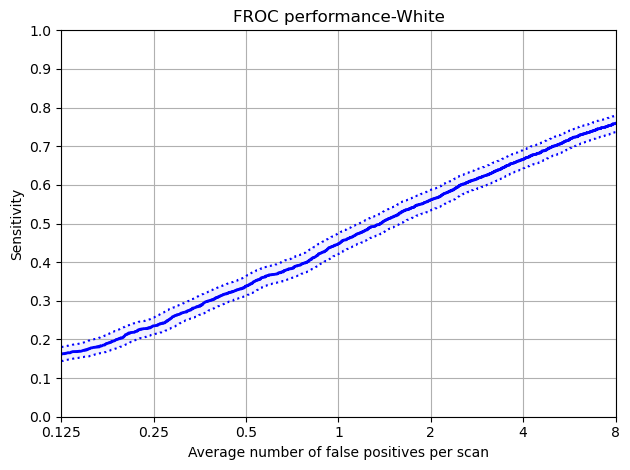

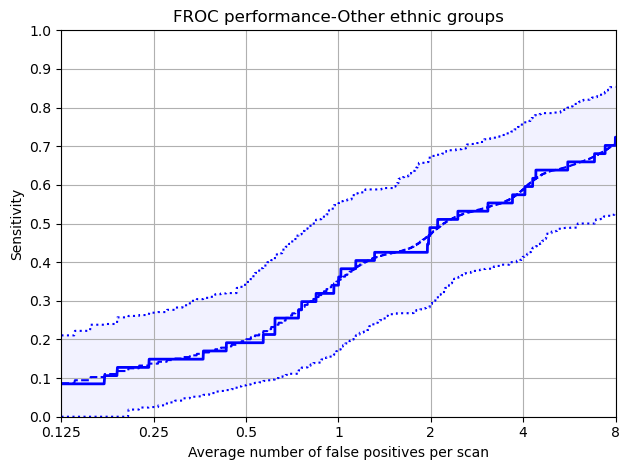

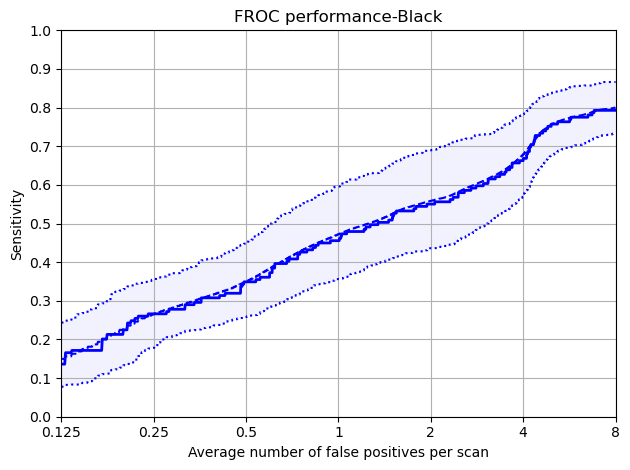

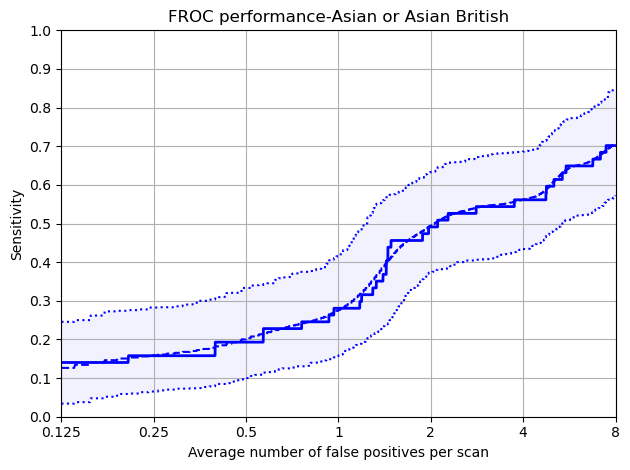

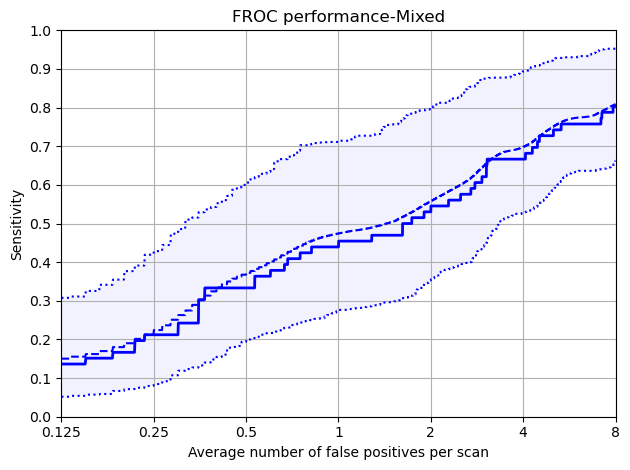

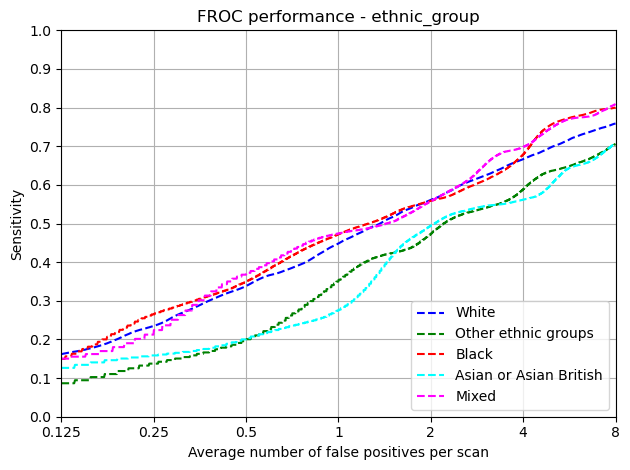

In [5]:
protected_group = 'ethnic_group'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/female_for_inference/{protected_group}'
)

### IMDRank_tertile

Protected Group: Low


SOLID  PERIFISSURAL  PART_SOLID  NON_SOLID  CALCIFIED
nodule_type   30.0          45.0         6.0        7.0       12.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpslk7kz5q/annotations.csv
Total number of included nodule annotations: 962
Total number of nodule annotations: 962
Cases: 754


100%|██████████| 1000/1000 [01:36<00:00, 10.38it/s]


0                   159                476   \
0  0.16 (0.13 - 0.18)  0.25 (0.21 - 0.28)  0.34 (0.3 - 0.38)   

                1111                2381                4920  \
0  0.45 (0.41 - 0.5)  0.58 (0.54 - 0.63)  0.68 (0.64 - 0.72)   

                 9999  
0  0.77 (0.73 - 0.81)

fps  mean_sens  low_sens  high_sens
0     0.12       0.16      0.13       0.18
159   0.25       0.25      0.21       0.28
476   0.50       0.34      0.30       0.38
1111  1.00       0.45      0.41       0.50
2381  2.00       0.58      0.54       0.63
4920  4.00       0.68      0.64       0.72
9999  8.00       0.77      0.73       0.81

Mean Sensitivity: 0.46 Low Sensitivity: 0.42 High Sensitivity: 0.5


True positives        827
0                                    False positives  37966.000
1                                    False negatives    135.000
2                                     True negatives      0.000
3                         Total number of candidates  38812.000
4                            Total number of nodules    962.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...     19.000
7                                        Sensitivity      0.860
8              Average number of candidates per scan     51.475

Protected Group: High


SOLID  PERIFISSURAL  PART_SOLID  NON_SOLID  CALCIFIED
nodule_type   26.0          48.0         7.0        9.0       10.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmprcrkhsu3/annotations.csv
Total number of included nodule annotations: 1043
Total number of nodule annotations: 1043
Cases: 793


100%|██████████| 1000/1000 [01:29<00:00, 11.13it/s]


0                   159                 476   \
0  0.16 (0.13 - 0.19)  0.23 (0.19 - 0.27)  0.32 (0.28 - 0.36)   

                 1111                2381               4920  \
0  0.43 (0.39 - 0.47)  0.52 (0.48 - 0.56)  0.64 (0.6 - 0.68)   

                 9999  
0  0.74 (0.71 - 0.78)

fps  mean_sens  low_sens  high_sens
0     0.12       0.16      0.13       0.19
159   0.25       0.23      0.19       0.27
476   0.50       0.32      0.28       0.36
1111  1.00       0.43      0.39       0.47
2381  2.00       0.52      0.48       0.56
4920  4.00       0.64      0.60       0.68
9999  8.00       0.74      0.71       0.78

Mean Sensitivity: 0.43 Low Sensitivity: 0.4 High Sensitivity: 0.47


True positives        868
0                                    False positives  40052.000
1                                    False negatives    175.000
2                                     True negatives      0.000
3                         Total number of candidates  40946.000
4                            Total number of nodules   1043.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...     26.000
7                                        Sensitivity      0.832
8              Average number of candidates per scan     51.634

Protected Group: Medium


SOLID  PERIFISSURAL  PART_SOLID  NON_SOLID  CALCIFIED
nodule_type   31.0          50.0         6.0        5.0        9.0

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpusl9x8s2/annotations.csv
Total number of included nodule annotations: 960
Total number of nodule annotations: 960
Cases: 751
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-8739-emz_Y0_BASELINE_A, nodule Annot ID: 2448
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-5854-bku_Y0_BASELINE_A, nodule Annot ID: 1507
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: 1802
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6225-qvf_Y0_BASELINE_A, nodule Annot ID: 1561


100%|██████████| 1000/1000 [01:17<00:00, 12.97it/s]


0                   159                476   \
0  0.16 (0.13 - 0.19)  0.22 (0.19 - 0.26)  0.34 (0.3 - 0.39)   

                1111                2381                4920  \
0  0.46 (0.41 - 0.5)  0.57 (0.53 - 0.61)  0.67 (0.63 - 0.71)   

                 9999  
0  0.76 (0.73 - 0.79)

fps  mean_sens  low_sens  high_sens
0     0.12       0.16      0.13       0.19
159   0.25       0.22      0.19       0.26
476   0.50       0.34      0.30       0.39
1111  1.00       0.46      0.41       0.50
2381  2.00       0.57      0.53       0.61
4920  4.00       0.67      0.63       0.71
9999  8.00       0.76      0.73       0.79

Mean Sensitivity: 0.45 Low Sensitivity: 0.42 High Sensitivity: 0.49


True positives        825
0                                    False positives  37209.000
1                                    False negatives    135.000
2                                     True negatives      0.000
3                         Total number of candidates  38057.000
4                            Total number of nodules    960.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...     27.000
7                                        Sensitivity      0.859
8              Average number of candidates per scan     50.675

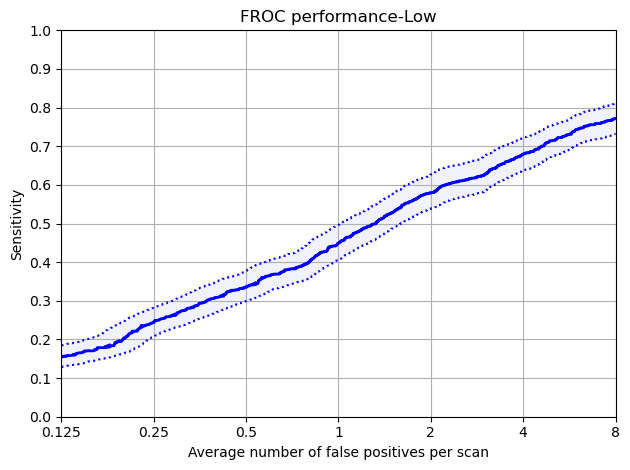

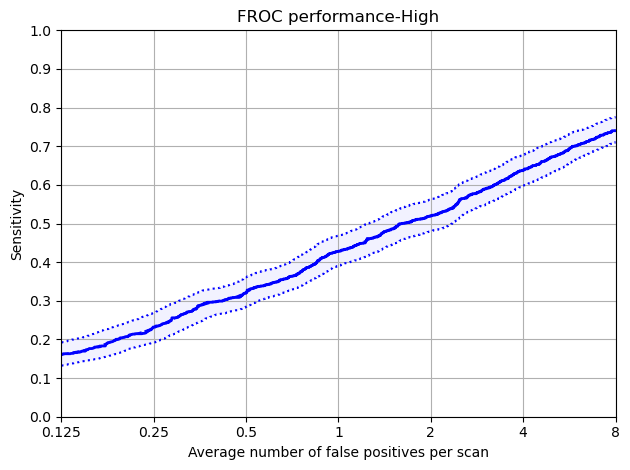

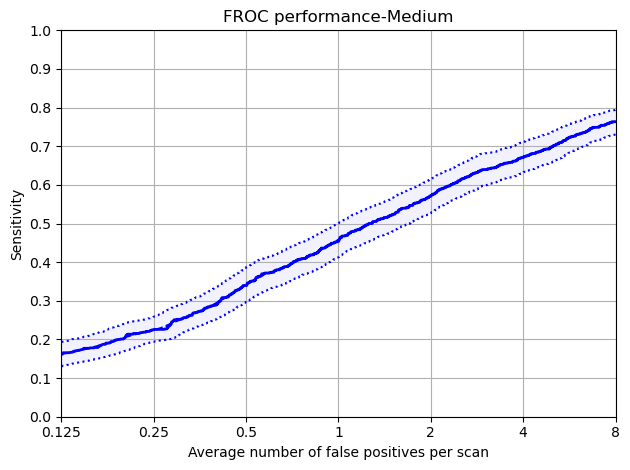

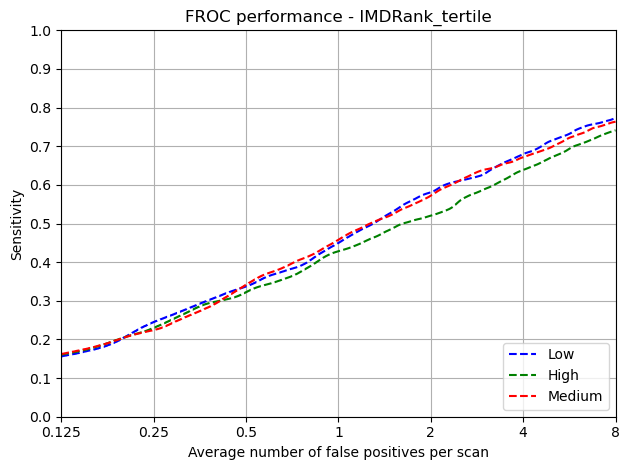

In [6]:
protected_group = 'IMDRank_tertile'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/female_for_inference/{protected_group}'
)

### Smoking Pack Years


In [7]:
protected_group = 'smoking_pack_years_cats'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/female_for_inference/{protected_group}'
)

Protected Group: 4.0


SOLID  PERIFISSURAL  PART_SOLID  NON_SOLID  CALCIFIED
nodule_type   33.0          43.0         6.0        8.0       10.0

TypeError: unsupported operand type(s) for /: 'PosixPath' and 'float'

### Actionable Vs Non-Actionable

In [ ]:
protected_group = 'is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/female_for_inference/{protected_group}'
)

### Actionable-Gender Splits

In [ ]:
protected_group = 'gender_is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/female_for_inference/{protected_group}'
)

### NonActionable-Gender

In [ ]:
protected_group = 'gender_is_not_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/female_for_inference/{protected_group}'
)

### Actionable Ethnic Group

In [ ]:
protected_group = 'ethnic_group_is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/female_for_inference/{protected_group}'
)

### NonActionable Ethnic Group

In [ ]:
protected_group = 'ethnic_group_is_not_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/female_for_inference/{protected_group}'
)

### Actionable IMDRank

In [ ]:
protected_group = 'imdrank_is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/female_for_inference/{protected_group}'
)

### Actionable Smoking Status

In [ ]:
protected_group = 'smoking_pack_years_is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/female_for_inference/{protected_group}'
)

### False positive and Miss Investigations

In [ ]:
import importlib
import utils

importlib.reload(utils)

In [ ]:
thresholds = utils.get_thresholds(grt123_summit_summit)
missed_metadata = utils.miss_anaysis_at_fpps(
    model='grt123',
    scans_metadata=scan_metadata,
    scans_path=f'{workspace_path}/metadata/summit/female_for_inference/test_scans.csv',
    annotations_path=f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/female_for_inference/female_for_inference_metadata.csv',
    exclusions_path=f'{workspace_path}/data/summit/metadata/grt123_annotations_excluded_empty.csv',
    predictions_path=f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/female_for_inference/female_for_inference_predictions.csv',
    thresholds=thresholds
)


#### Incremental FROC Scores - Gender/ Ethnic Group/ Nodule Type

In [ ]:

hit_and_miss_dict = utils.get_protected_group_by_nodule_type(missed_metadata)


In [ ]:


recode_dict = {}
for idx in range(7):
    hmm = {}
    for slice in ['all','actionable']:
        for protected_group in ['MALE','FEMALE','All', 'Asian or Asian British', 'Black', 'White']:
            for type in ['SOLID','NON_SOLID','PART_SOLID','PERIFISSURAL','CALCIFIED']:
            
                try:

                    group = 'gender' if protected_group in ['MALE','FEMALE','All'] else 'ethnic_group'

                    total = hit_and_miss_dict[idx][slice][group][(True,type)][protected_group] + hit_and_miss_dict[idx][slice][group][(False,type)][protected_group]
                    hits = hit_and_miss_dict[idx][slice][group][(False,type)][protected_group]
                    perc_hits = round(100 * (hits/total),0)

                    hmm[f'{slice}_{protected_group}_{type}_Hits%'] = perc_hits
                except:
                    print(f'Error: {idx}, {slice}, {protected_group}, {type}')
                    pass

    recode_dict[idx] = hmm

df = pd.DataFrame.from_dict(recode_dict, orient='index')

# Remove ".0" from each value in the dataframe
df = df.applymap(lambda x: str(x).replace('.0', ''))

# Collapse each column into comma-delimited values
collapsed_df = df.apply(lambda x: ', '.join(x), axis=0)

display(collapsed_df)

from scipy.stats import shapiro, ttest_ind, mannwhitneyu

def calculate_significant_differences(df, group1_name, group2_name):

    group1 = df[group1_name].astype(int).values
    group2 = df[group2_name].astype(int).values

    shapiro_group1 = shapiro(group1)
    shapiro_group2 = shapiro(group2)

    print('*'*50)
    if shapiro_group1[1] > 0.05 and shapiro_group2[1] > 0.05:
        t_test = ttest_ind(group1, group2)
        print(f'Independent T-Test: {round(t_test.statistic,3)}, {round(t_test.pvalue,3)}')
    else:
        manwhitney = mannwhitneyu(group1, group2)
        print(f'Mann-Whitney U Test: {round(manwhitney.statistic,3)}, {round(manwhitney.pvalue,3)}')

for type in ['SOLID','NON_SOLID','PART_SOLID','PERIFISSURAL','CALCIFIED']:

    print(f'*** {type} ***')
    group1 = f'all_White_{type}_Hits%'
    group2 = f'all_Asian or Asian British_{type}_Hits%'
    calculate_significant_differences(df, group1, group2)

#### Nodule Characteristic Analysis

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

nodule_characteristics = {
    'nodule_site_combined2': ['RIGHT', 'LEFT', 'NOT_ANSWERED'],
    'nodule_site_combined': ['UPPER','NOT-UPPER', 'NOT_ANSWERED'],
    'nodule_type': ['SOLID', 'NON_SOLID', 'PART_SOLID', 'PERIFISSURAL', 'CALCIFIED'],
    'management_plan': ['RANDOMISATION_AT_YEAR_1','ALWAYS_SCAN_AT_YEAR_1', '3_MONTH_FOLLOW_UP_SCAN', 'URGENT_REFERRAL'],
    'diameter_cats': diameter_lbs,
}

for ivx, (var, order) in enumerate(nodule_characteristics.items()):
    annotations = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/female_for_inference/female_for_inference_metadata.csv')
    # annotations = annotations[annotations['management_plan'] != 'RANDOMISATION_AT_YEAR_1']

    total_vc = annotations[var].value_counts().sort_index().rename('Total Annotations')

    operating_points = ['0.125', '0.25', '0.5', '1', '2', '4', '8']

    results = []

    for idx, metadata in enumerate(missed_metadata):
        results.append(
            pd.crosstab(
                metadata[var], 
                metadata['miss'],
                normalize='index'
            )[False]
            .rename(f'{operating_points[idx]}')
            .reindex(order)
            
        )

    df = pd.concat(results, axis=1).fillna(0).round(2).merge(total_vc.to_frame(), left_index=True, right_index=True)

    display(df.T)


    line_styles = ['-', '--', '-.', ':', '-', '--', '-.']
    weights = df.pop('Total Annotations')

    for isx, column in enumerate(df.T):    
            ax[ivx].plot(df.T[column], label=column, linestyle=line_styles[isx], linewidth=weights[isx]/100)
    
    ax[ivx].set_xticklabels(labels=df.columns, rotation=45)
    ax[ivx].set_title(var)
    ax[ivx].legend()
    ax[ivx].set_ylabel('% of Hits')
    ax[ivx].grid(visible=True, which='both')

plt.suptitle('Category Hits at Different FPPs')
plt.show()

In [ ]:
missed_at_lowest = missed_metadata[0]
hits = missed_at_lowest[missed_at_lowest['miss'] == False]

(
    pd.crosstab(
        [
            hits['diameter_cats'],
            hits['nodule_type']
        ], 
        hits['nodule_site_combined'],
        normalize='all'
    )[['UPPER','NOT-UPPER']]
    .apply(lambda x: round(100 * x, 1))
)

In [ ]:
thresholds = get_thresholds(grt123_summit_summit)

scans = pd.read_csv(f'{workspace_path}/metadata/summit/female_for_inference/test_scans.csv')
predictions = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/female_for_inference/female_for_inference_predictions.csv')
annotations = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/female_for_inference/female_for_inference_metadata.csv')

false_positives_fpps = false_positive_analysis(
    thresholds=thresholds,    
    predictions=predictions,
    annotations=annotations
)

#### Examples of False Positives

In [ ]:
cnt = 0

df = false_positives_fpps['0.125']

for idx, row in df[df.distance_false_positive].sort_values(by='threshold', ascending=False).iterrows():
    study_id = row['name']
    x = row['row']
    y = row['col']
    z = row['index']
    diameter = row['diameter']
    

    copy_scan_from_cluster(study_id)
    show_numpy_candidate_location(study_id, x, y, z, diameter, row.distance_false_positive, row.iou_false_positive)
    cnt+=1
    if cnt == 12:
        break

## MONAI Detection

In [ ]:

detection_predictions_path = combine_predictions(f'{workspace_path}/models/detection/result/trained_summit/summit/female_for_inference', 'test')
detection_predictions = pd.read_csv(detection_predictions_path)

annotations = (
    pd.read_csv(f'{workspace_path}/metadata/summit/female_for_inference/test_metadata.csv')
    .assign(name=lambda df: df.participant_id + '_Y0_BASELINE_A')
    .assign(row=lambda df: df['nodule_x_coordinate'])
    .assign(col=lambda df: df['nodule_y_coordinate'])
    .assign(index=lambda df: df['nodule_z_coordinate'])
    .assign(diameter=lambda df: df['nodule_diameter_mm'])
    .assign(diameter_cats=lambda df: pd.cut(
        df['nodule_diameter_mm'],
        bins=diameter_cats,
        labels=diameter_lbs
    ))
    .assign(nodule_site_combined=lambda df: df['nodule_site'].apply(combine_site))
    .assign(nodule_site_combined2=lambda df: df['nodule_site'].apply(combine_site2))
)

annotations.to_csv(f'{workspace_path}/models/detection/result/trained_summit/summit/female_for_inference/annotations.csv', index=False)

detection_summit_summit = noduleCADEvaluation(
    annotations_filename=f'{workspace_path}/models/detection/result/trained_summit/summit/female_for_inference/annotations.csv',
    annotations_excluded_filename=f'{workspace_path}/data/summit/metadata/annotations_excluded_empty.csv',
    seriesuids_filename=f'{workspace_path}/metadata/summit/female_for_inference/test_scans.csv',
    results_filename=detection_predictions_path,
    filter='\nModel 2 trained on SUMMIT dataset and evaluated on SUMMIT dataset\n',
    outputDir=f'{workspace_path}/results/detection/trained_summit/summit/female_for_inference',
)
caluclate_cpm_from_bootstrapping(f'{workspace_path}/results/detection/trained_summit/summit/female_for_inference/froc_predictions_bootstrapping.csv')
show_metrics(f'{workspace_path}/results/detection/trained_summit/summit/female_for_inference/CADAnalysis.txt')


### Gender analysis

In [ ]:


annotations = pd.read_csv(f'{workspace_path}/models/detection/result/trained_summit/summit/female_for_inference/annotations.csv')

predictions = pd.read_csv(detection_predictions_path)

protected_group = 'gender'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/female_for_inference/{protected_group}'
)

### Ethnicity Analysis

In [ ]:
protected_group = 'ethnic_group'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/female_for_inference/{protected_group}'
)

### IMDRank_tertile

In [ ]:
protected_group = 'IMDRank_tertile'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/female_for_inference/{protected_group}'
)

### Smoking Pack Years


In [ ]:
protected_group = 'smoking_pack_years_cats'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/female_for_inference/{protected_group}'
)

### Actionable Vs Non-Actionable

In [ ]:
protected_group = 'is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/female_for_inference/{protected_group}'
)

### Actionable Gender

In [ ]:
protected_group = 'gender_is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/female_for_inference/{protected_group}'
)


### Non-Actionable Gender

In [ ]:
protected_group = 'gender_is_not_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/female_for_inference/{protected_group}'
)

### Actionable Ethnic Group

In [ ]:
protected_group = 'ethnic_group_is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/female_for_inference/{protected_group}'
)


### NonActionable - Ethnic Group

In [ ]:
protected_group = 'ethnic_group_is_not_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/female_for_inference/{protected_group}'
)

### Actionable IMDRank

In [ ]:
protected_group = 'imdrank_is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/female_for_inference/{protected_group}'
)

### Actionable Smoking Status

In [ ]:
protected_group = 'smoking_pack_years_is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/female_for_inference/{protected_group}'
)


### False Positive and Miss Analysis


In [ ]:
thresholds = utils.get_thresholds(detection_summit_summit)
print(thresholds)
missed_metadata = utils.miss_anaysis_at_fpps(
    model='detection',
    scans_metadata=scan_metadata,
    scans_path=f'{workspace_path}/metadata/summit/female_for_inference/test_scans.csv',
    annotations_path=f'{workspace_path}/models/detection/result/trained_summit/summit/female_for_inference/annotations.csv',
    exclusions_path=f'{workspace_path}/data/summit/metadata/annotations_excluded_empty.csv',
    predictions_path=detection_predictions_path,
    thresholds=thresholds
)

In [ ]:
hit_and_miss_dict = utils.get_protected_group_by_nodule_type(missed_metadata)

#### Incremental FROC Scores - Gender/ Ethnic Group / Nodule Type

In [ ]:

# display(hit_and_miss_dict[0])
recode_dict = {}
for idx in range(7):
    hmm = {}
    for slice in ['all','actionable']:
        for protected_group in ['MALE','FEMALE','All', 'Asian or Asian British', 'Black', 'White']:
            for type in ['SOLID','NON_SOLID','PART_SOLID','PERIFISSURAL','CALCIFIED']:
            
                try:

                    group = 'gender' if protected_group in ['MALE','FEMALE','All'] else 'ethnic_group'

                    total = hit_and_miss_dict[idx][slice][group][(True,type)][protected_group] + hit_and_miss_dict[idx][slice][group][(False,type)][protected_group]
                    hits = hit_and_miss_dict[idx][slice][group][(False,type)][protected_group]
                    perc_hits = round(100 * (hits/total),0)

                    hmm[f'{slice}_{protected_group}_{type}_Hits%'] = perc_hits
                except:
                    print(f'Error: {idx}, {slice}, {protected_group}, {type}')
                    hmm[f'{slice}_{protected_group}_{type}_Hits%'] = 100
                    

    recode_dict[idx] = hmm

pd.DataFrame.from_dict(recode_dict, orient='index').head(7)

df = pd.DataFrame.from_dict(recode_dict, orient='index').head(7)

# Remove ".0" from each value in the dataframe
df = df.applymap(lambda x: str(x).replace('.0', ''))

# Collapse each column into comma-delimited values
collapsed_df = df.apply(lambda x: ', '.join(x), axis=0)

display(collapsed_df)

from scipy.stats import shapiro, ttest_ind, mannwhitneyu

def calculate_significant_differences(df, group1_name, group2_name):

    group1 = df[group1_name].astype(int).values
    group2 = df[group2_name].astype(int).values

    shapiro_group1 = shapiro(group1)
    shapiro_group2 = shapiro(group2)

    print('*'*50)
    if shapiro_group1[1] > 0.05 and shapiro_group2[1] > 0.05:
        t_test = ttest_ind(group1, group2)
        print(f'Independent T-Test: {round(t_test.statistic,3)}, {round(t_test.pvalue,3)}')
    else:
        manwhitney = mannwhitneyu(group1, group2)
        print(f'Mann-Whitney U Test: {round(manwhitney.statistic,3)}, {round(manwhitney.pvalue,3)}')

a='White'
b='Black'

for type in ['SOLID','NON_SOLID','PART_SOLID','PERIFISSURAL','CALCIFIED']:

    print(f'*** all {type} ***')
    group1 = f'all_{a}_{type}_Hits%'
    group2 = f'all_{b}_{type}_Hits%'
    calculate_significant_differences(df, group1, group2)

for type in ['SOLID','NON_SOLID','PART_SOLID','PERIFISSURAL','CALCIFIED']:

    print(f'*** actionable {type} ***')
    group1 = f'actionable_{a}_{type}_Hits%'
    group2 = f'actionable_{b}_{type}_Hits%'
    calculate_significant_differences(df, group1, group2)

#### Nodule Characteristic Analysis

In [ ]:

fig, ax = plt.subplots(1, 5, figsize=(20, 5))

nodule_characteristics = {
    'nodule_site_combined2': ['RIGHT', 'LEFT', 'NOT_ANSWERED'],
    'nodule_site_combined': ['UPPER','NOT-UPPER', 'NOT_ANSWERED'],
    'nodule_type': ['SOLID', 'NON_SOLID', 'PART_SOLID', 'PERIFISSURAL', 'CALCIFIED'],
    'management_plan': ['RANDOMISATION_AT_YEAR_1','ALWAYS_SCAN_AT_YEAR_1', '3_MONTH_FOLLOW_UP_SCAN', 'URGENT_REFERRAL'],
    'diameter_cats': diameter_lbs,
}

for ivx, (var, order) in enumerate(nodule_characteristics.items()):
    annotations = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/female_for_inference/female_for_inference_metadata.csv')
    # annotations = annotations[annotations['management_plan'] != 'RANDOMISATION_AT_YEAR_1']

    total_vc = annotations[var].value_counts().sort_index().rename('Total Annotations')

    operating_points = ['0.125', '0.25', '0.5', '1', '2', '4', '8']

    results = []

    for idx, metadata in enumerate(missed_metadata):
        results.append(
            pd.crosstab(
                metadata[var], 
                metadata['miss'],
                normalize='index'
            )[False]
            .rename(f'{operating_points[idx]}')
            .reindex(order)
            
        )

    df = pd.concat(results, axis=1).fillna(0).round(2).merge(total_vc.to_frame(), left_index=True, right_index=True)

    display(df.T)


    line_styles = ['-', '--', '-.', ':', '-', '--', '-.']
    weights = df.pop('Total Annotations')

    for isx, column in enumerate(df.T):    
            ax[ivx].plot(df.T[column], label=column, linestyle=line_styles[isx], linewidth=weights[isx]/100)
    
    ax[ivx].set_xticklabels(labels=df.columns, rotation=45)
    ax[ivx].set_title(var)
    ax[ivx].legend()
    ax[ivx].set_ylabel('% of Hits')
    ax[ivx].grid(visible=True, which='both')

plt.suptitle('Category Hits at Different FPPs')
plt.show()

In [ ]:
# Check what nodules have been missed by gender


missed_metadata_at_2fpps = missed_metadata[4]

def crosstab_with_percentages(rows, columns, x_order=None, y_order=None, table=False, heatmap=False):
    # Create the crosstab with absolutes
    cols = [c.astype(str) for c in columns]
    rows = [r.astype(str) for r in rows]

    xabs = pd.crosstab(rows, cols).fillna(0)
    xperc = pd.crosstab(rows, cols, normalize='columns').fillna(0)

    if x_order:
        xabs = xabs.reindex(x_order, axis=1)
        xperc = xperc.reindex(x_order, axis=1)

    if y_order:
        xabs = xabs.reindex(y_order)
        xperc = xperc.reindex(y_order)

    combined_data = {}

    for (adx, rabs), (pdx, rperc) in zip(xabs.iterrows(), xperc.iterrows()):

        row_data = {}
        row_total = 0

        for col in xabs.columns:
            row_data[col] = f"{rabs[col]} ({rperc[col]:.1%})"
            row_total += rabs[col]

        row_data['Total'] = f'{row_total} ({row_total / xabs.sum().sum():.1%})'
        combined_data[adx] = row_data

    row_data = {}
    row_total = 0
    for col in xabs.columns:
        row_data[col] = f'{sum(xabs[col])}'
        row_total += xabs[col].sum()

    row_data['Total'] = row_total
    combined_data['Total'] = row_data

    if table:
        display(pd.DataFrame.from_dict(combined_data).T)
        
    
    if heatmap:
        sns.heatmap(xperc, annot=True, fmt=".1%", cmap='Blues')
        plt.show()

    return xperc, pd.DataFrame.from_dict(combined_data)

_ = crosstab_with_percentages(
    [missed_metadata_at_2fpps['nodule_type'], missed_metadata_at_2fpps['management_plan']],
    [missed_metadata_at_2fpps['gender']],
    table=True,
    heatmap=True)

In [ ]:
scans = pd.read_csv(f'{workspace_path}/metadata/summit/female_for_inference/test_scans.csv')
predictions = pd.read_csv(detection_predictions_path)
annotations = pd.read_csv(f'{workspace_path}/models/detection/result/trained_summit/summit/female_for_inference/annotations.csv')

false_positives_fpps = false_positive_analysis(
    thresholds=thresholds,    
    predictions=predictions,
    annotations=annotations
)

#### Examples of False Positives

summit-7653-wpy_Y0_BASELINE_A already exists
summit-7653-wpy_Y0_BASELINE_A - 356 300 86 6.328125
False Positive: True
IoU False Positive: 0.0


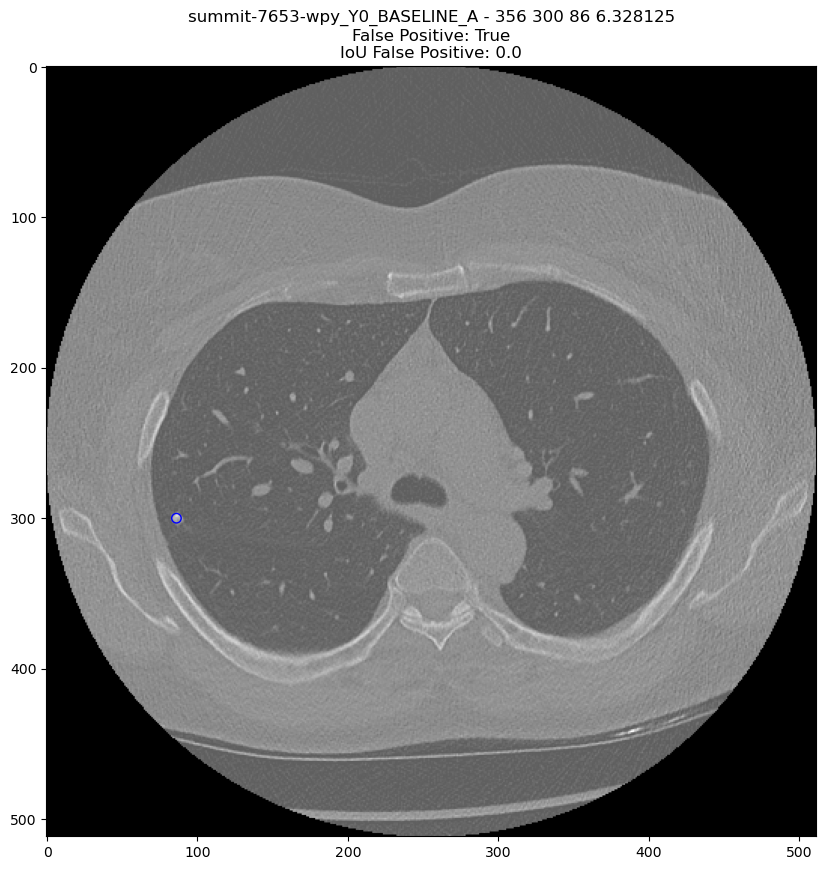

summit-3288-gfs_Y0_BASELINE_A already exists
summit-3288-gfs_Y0_BASELINE_A - 233 408 206 13.359375
False Positive: True
IoU False Positive: nan


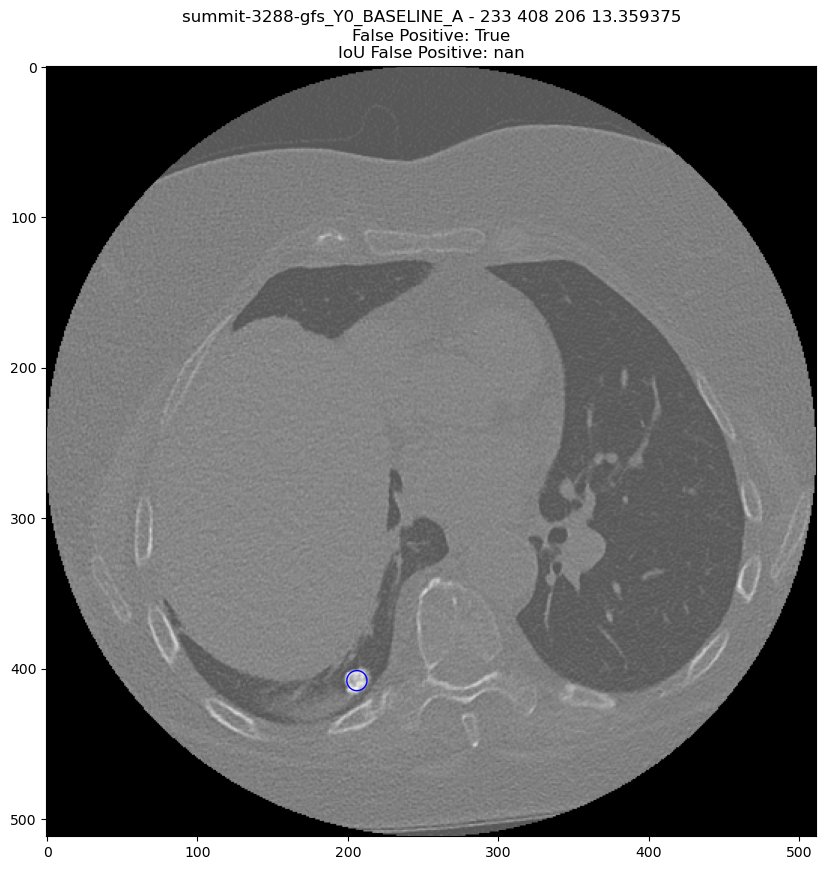

summit-3768-mgu_Y0_BASELINE_A already exists
summit-3768-mgu_Y0_BASELINE_A - 454 297 240 6.85546875
False Positive: True
IoU False Positive: 0.0


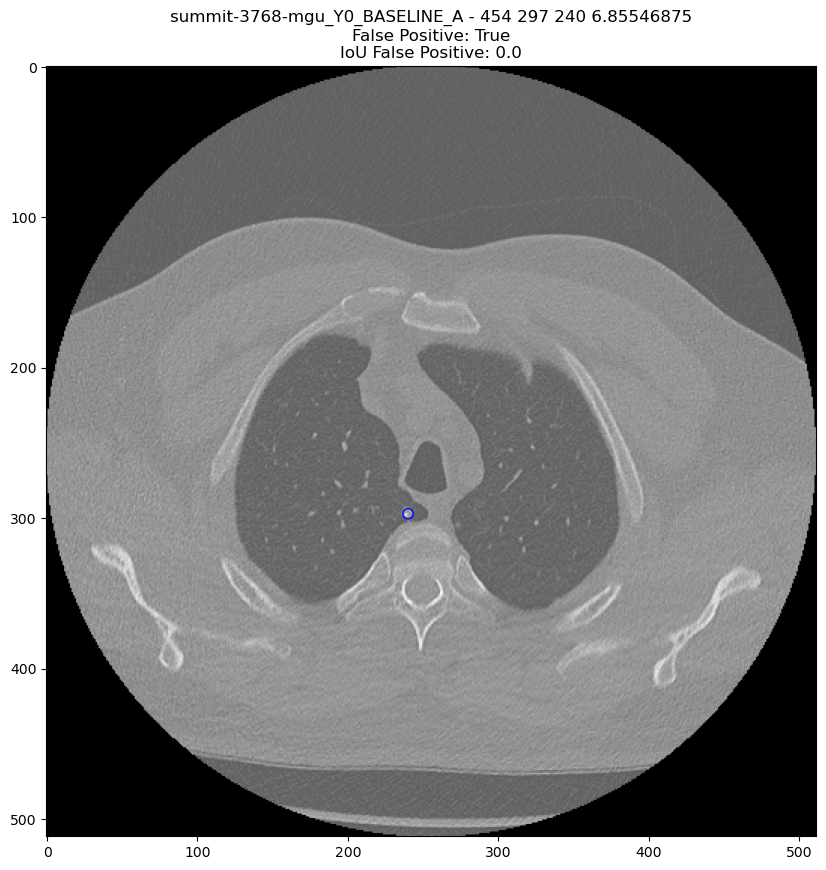

summit-8769-uas_Y0_BASELINE_A already exists
summit-8769-uas_Y0_BASELINE_A - 350 388 362 6.767578125
False Positive: True
IoU False Positive: nan


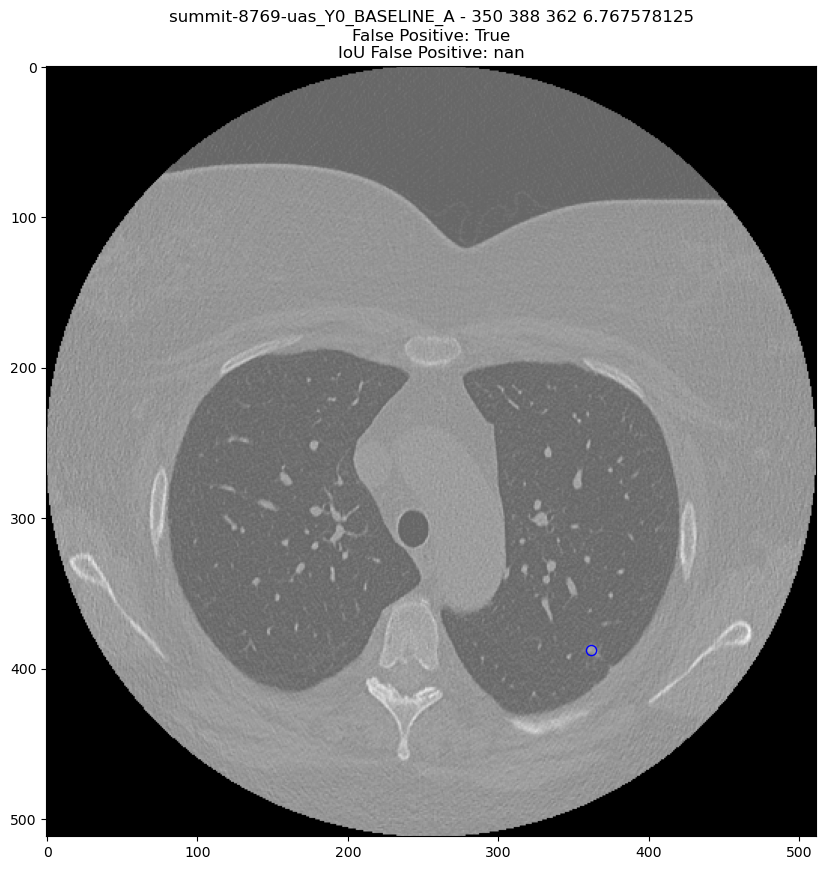

summit-8492-mxn_Y0_BASELINE_A already exists
summit-8492-mxn_Y0_BASELINE_A - 276 344 291 8.173828125
False Positive: True
IoU False Positive: 0.0


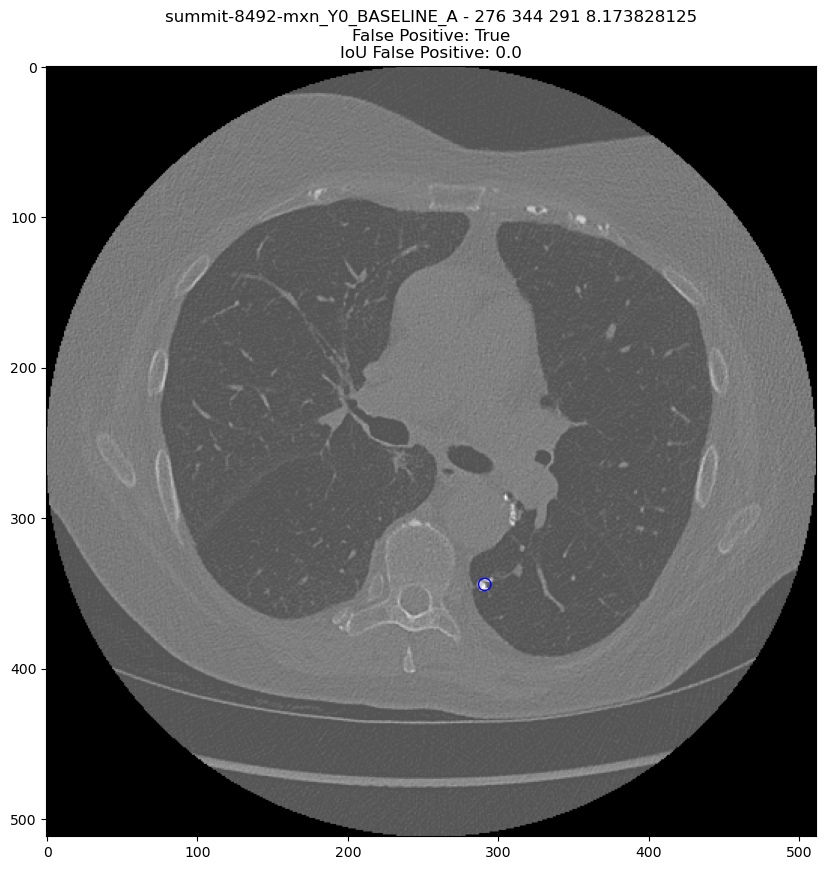

summit-3785-pcd_Y0_BASELINE_A already exists
summit-3785-pcd_Y0_BASELINE_A - 296 377 199 6.09375
False Positive: True
IoU False Positive: 0.0


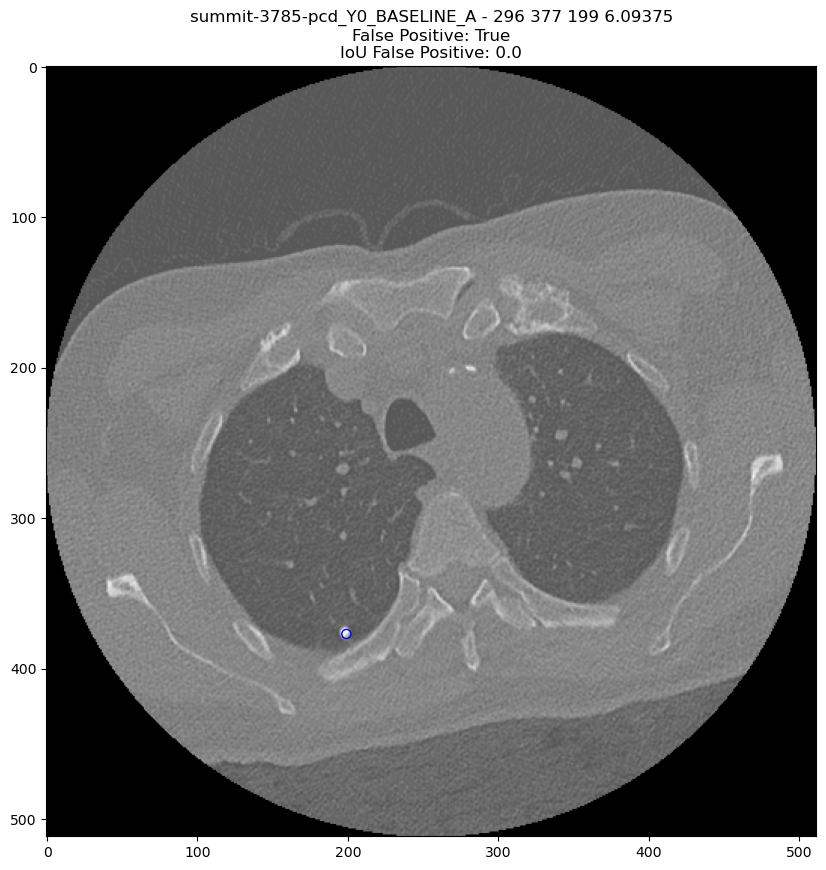

summit-3638-yab_Y0_BASELINE_A already exists
summit-3638-yab_Y0_BASELINE_A - 230 113 156 6.15234375
False Positive: True
IoU False Positive: nan


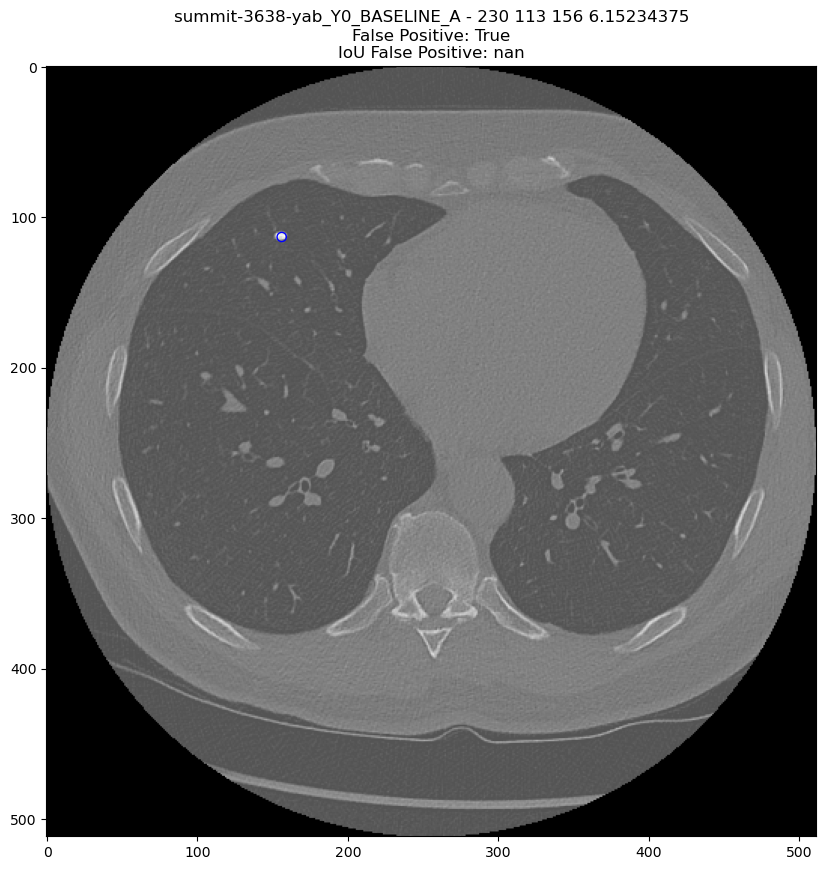

summit-6387-eye_Y0_BASELINE_A already exists
summit-6387-eye_Y0_BASELINE_A - 308 344 363 7.55859375
False Positive: True
IoU False Positive: nan


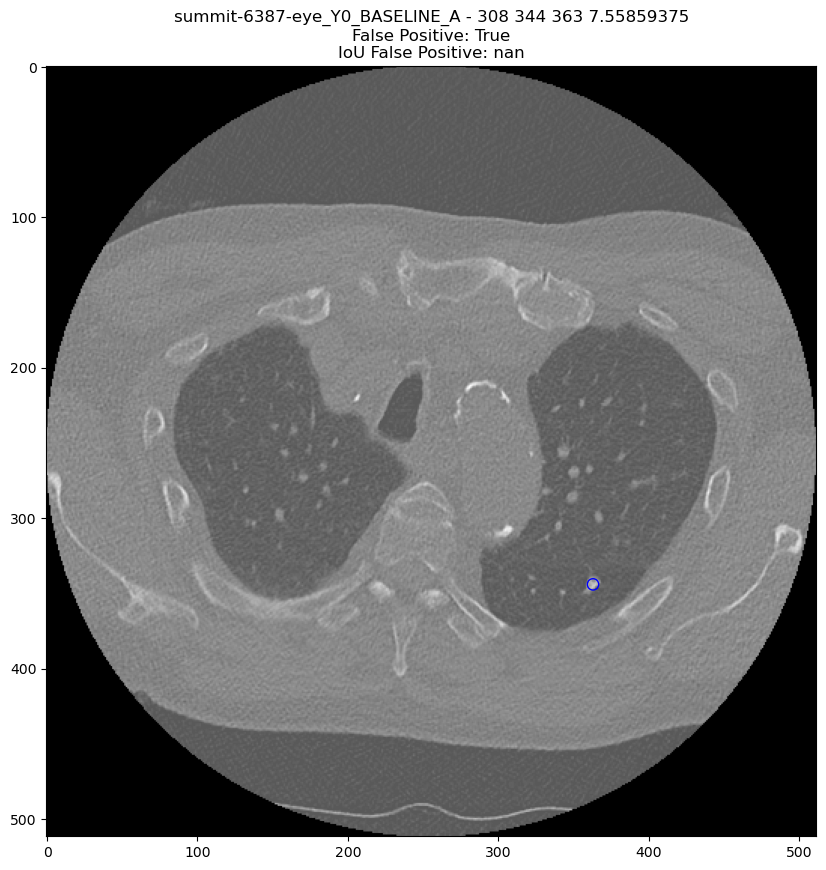

summit-6525-cdt_Y0_BASELINE_A already exists
summit-6525-cdt_Y0_BASELINE_A - 364 276 137 6.15234375
False Positive: True
IoU False Positive: nan


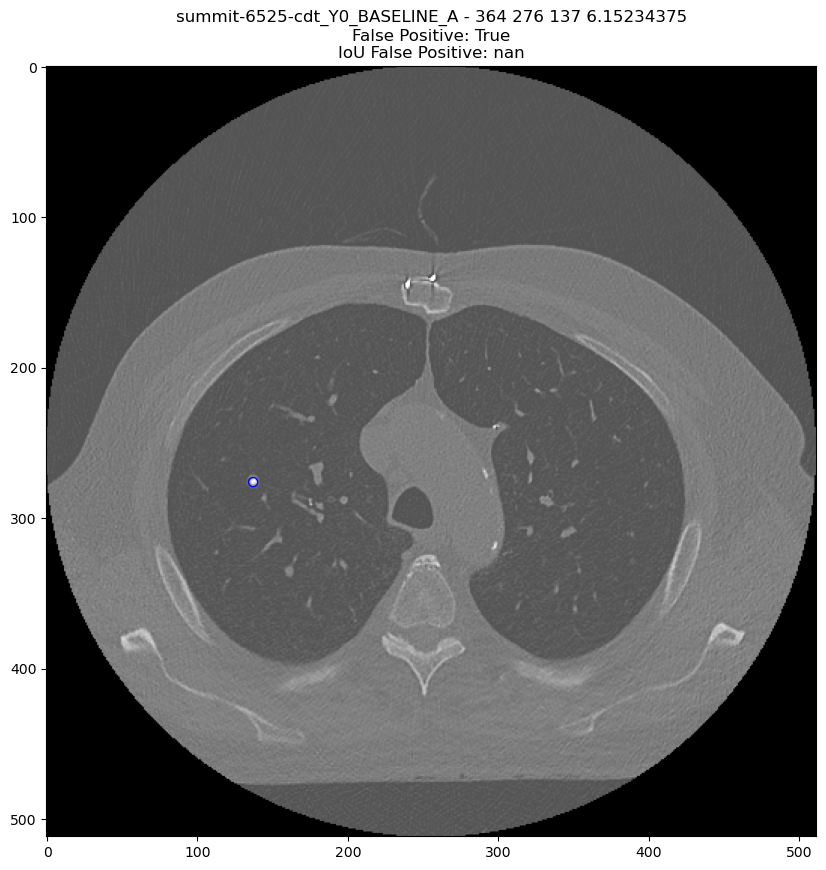

summit-9777-rvm_Y0_BASELINE_A already exists
summit-9777-rvm_Y0_BASELINE_A - 204 86 347 7.03125
False Positive: True
IoU False Positive: 0.0


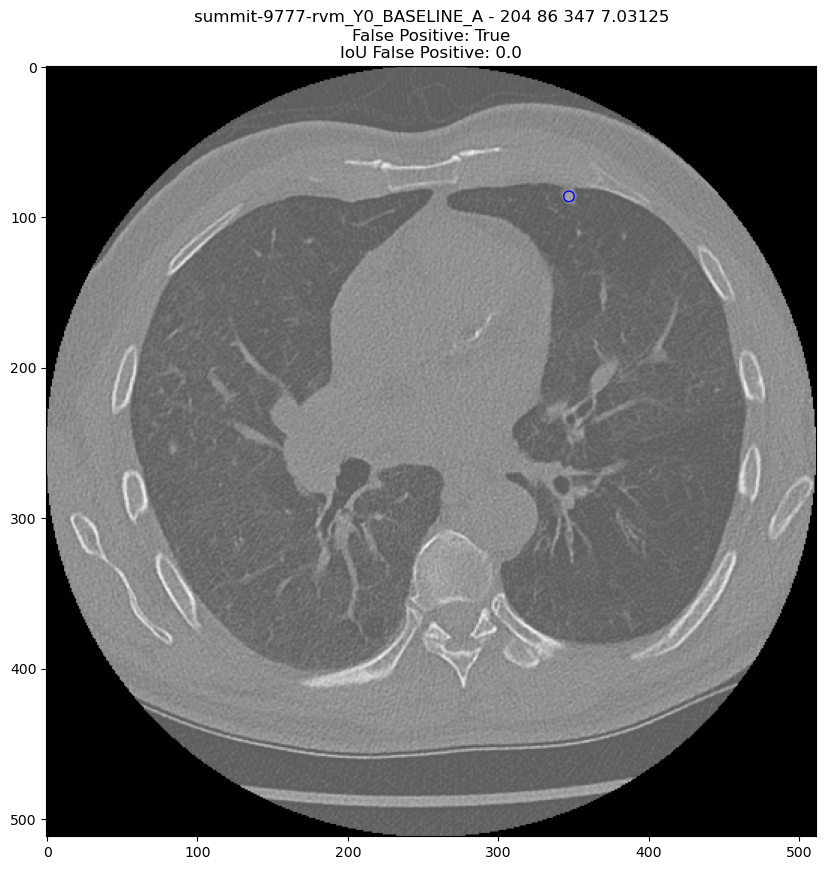

In [ ]:
df = false_positives_fpps['0.125']

cnt = 0
for idx, row in df[df.distance_false_positive].sort_values(by='threshold', ascending=False).iterrows():
    scan_id = row['name']
    study_id = scan_id.split('_')[0]
    x = row['row']
    y = row['col']
    z = row['index']
    diameter = row['diameter']
    

    copy_scan_from_cluster(scan_id)
    
    scan = SummitScan.load_scan(f'{workspace_path}/data/summit/scans/{study_id}/{scan_id}.mhd')
    irc = xyz2irc([x, y, z], scan.origin, scan.voxel_size, scan.orientation)


    show_mhd_candidate_location(scan_id, scan.image, irc.row, irc.col, irc.index, diameter, row.distance_false_positive, row.iou_false_positive)
    cnt+=1
    if cnt == 12:
        break